In [303]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import *
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [304]:
# df = pd.read_csv('./Datasets/bitcoin_price.csv', parse_dates=['Date'], usecols=['Date','Close'])
# df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv', parse_dates=['Timestamp'], usecols=['Timestamp','Close'])
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
df.isnull().values.any()
df.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
5,1325318220,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
6,1325318280,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
7,1325318340,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
8,1325318400,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
9,1325318460,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [357]:
df['Date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
# group = df.groupby('Date')
# Daily_Price = group['Weighted_Price'].mean()

# Daily_Price.head()

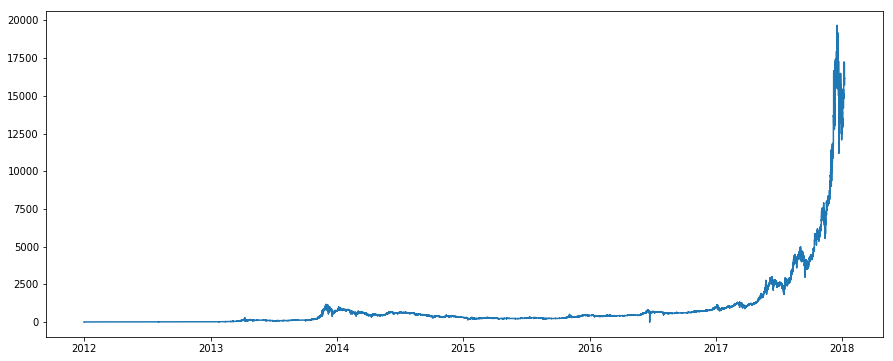

In [358]:
# convert the date column into a time series with daily frequency

df['Date'] = pd.to_datetime(df['Date'])

indexed_df = df.set_index('Date')

ts = indexed_df['Close']

ts.head()

# visualize the time series to see how Bitcoin changes over time

plt.plot(ts)

In [401]:
# resamply by week

ts_week = ts.resample('D').mean()

ts_week

# new_df= pd.DataFrame(list(ts_week), index = ts_week.index, columns = ["Close"])
# new_df= pd.DataFrame(list(ts_week), index = pd.date_range(ts_week.index,freq='D'), columns = ["Close"])
new_df= pd.DataFrame(list(ts_week), index = ts_week.index, columns = ["Close"])

ValueError: Of the three parameters: start, end, and periods, exactly two must be specified

In [360]:
new_df.head()

,Close
Date,
2011-12-31,4.472624
2012-01-01,4.680778
2012-01-02,5.000000
2012-01-03,5.145917
2012-01-04,5.228729


In [361]:
# new_df = new_df.fillna(lambda x: x.median())

In [362]:
len(new_df)

2201

In [382]:
train=new_df[0:2000] 
test=new_df[2000:]
# print(train.tail())
print(test.head())
# print(test.tail())
np.any(np.isnan(train.Close))

                  Close
Date                   
2017-06-22  2680.862333
2017-06-23  2718.264889
2017-06-24  2657.009215
2017-06-25  2559.341569
2017-06-26  2464.920389


True

In [383]:
np.all(np.isfinite(train.Close))

False

In [384]:
train.Close = train.Close.dropna()

/home/rahulworld/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [385]:
test.Close = test.Close.dropna()

/home/rahulworld/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [386]:
test[test==np.inf]=np.nan

/home/rahulworld/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rahulworld/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


In [387]:
test = test.dropna()

train = train.dropna()

In [388]:
np.all(np.isfinite(train.Close))

True

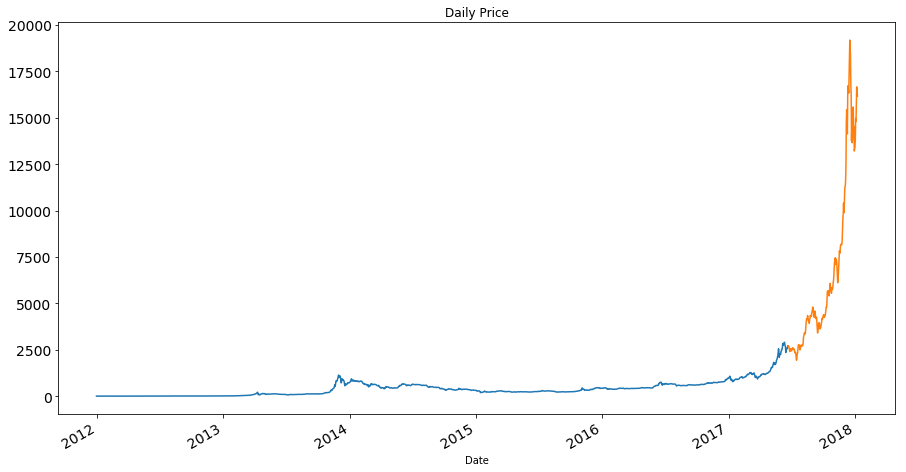

In [389]:
train.Close.plot(figsize=(15,8), title= 'Daily Price', fontsize=14)
test.Close.plot(figsize=(15,8), title= 'Daily Price', fontsize=14)
plt.show()

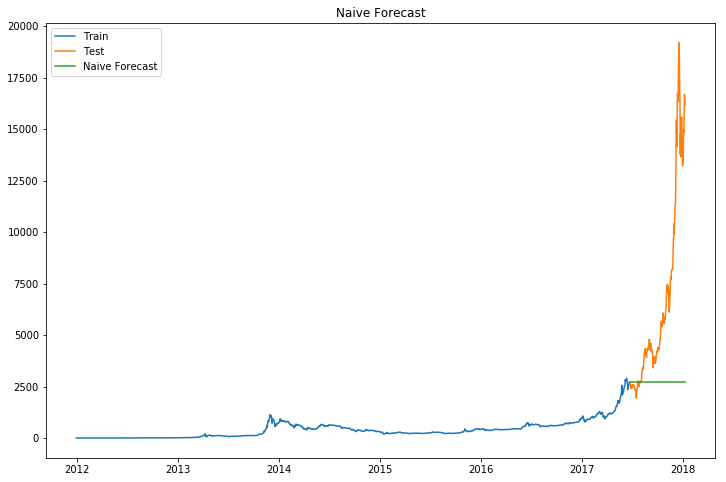

In [390]:
dd= np.asarray(train.Close)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

#ploting Graph between Train test NAIVE Approach for forecast
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index,test['Close'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [391]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Close, y_hat.naive))
print(rms)

5956.102669944819


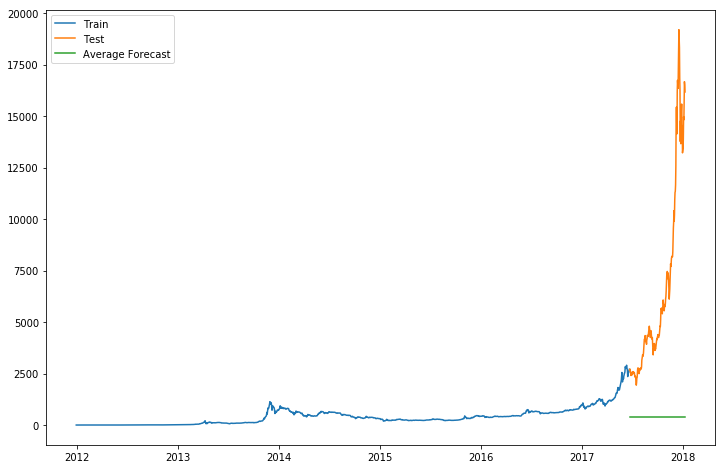

In [392]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Close'].mean()

plt.figure(figsize=(12,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [393]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.avg_forecast))
print(rms)

7653.748461193343


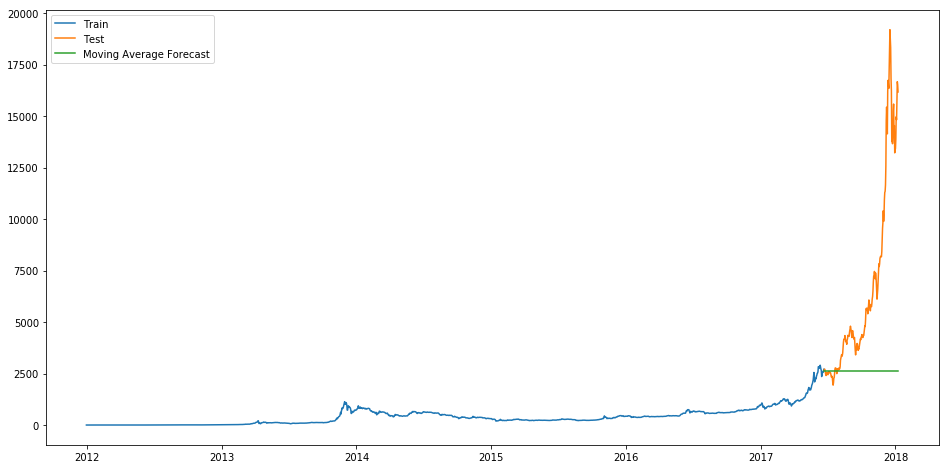

In [394]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Close'].rolling(10).mean().iloc[-1]

plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [395]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.moving_avg_forecast))
print(rms)

6027.1875898986145


In [396]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

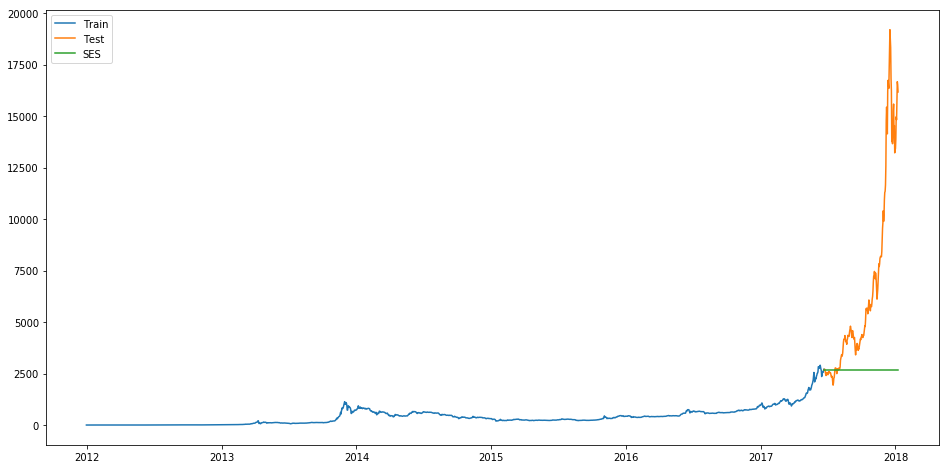

In [397]:
y_hat_avg = test.copy()
# print(y_hat_avg)
fit2 = SimpleExpSmoothing(np.asarray(train['Close'])).fit(smoothing_level=0.6,optimized=False)

y_hat_avg['SES'] = fit2.forecast(len(test))
# print(y_hat_avg['SES'])

plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [398]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.SES))
print(rms)

5980.438676360839


In [400]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Close,freq='D').plot()
result = sm.tsa.stattools.adfuller(train.Close)
plt.show()

TypeError: not all arguments converted during string formatting

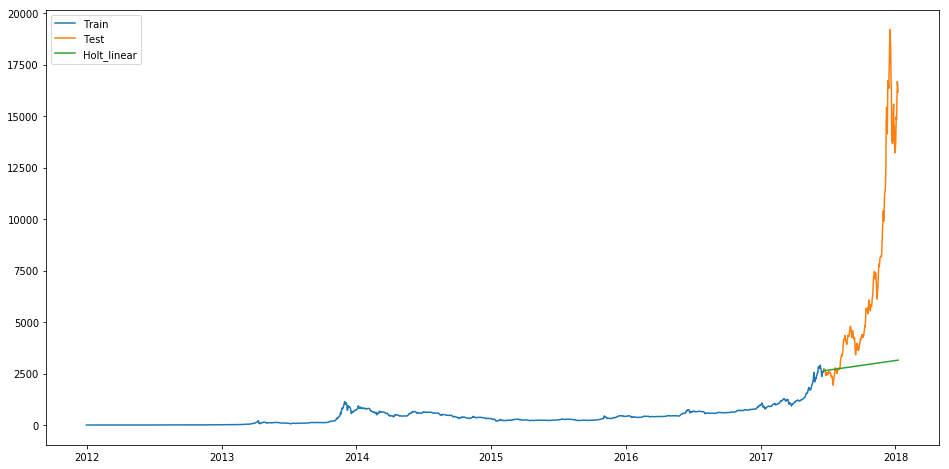

In [356]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Close'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [201]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.Holt_linear))
print(rms)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

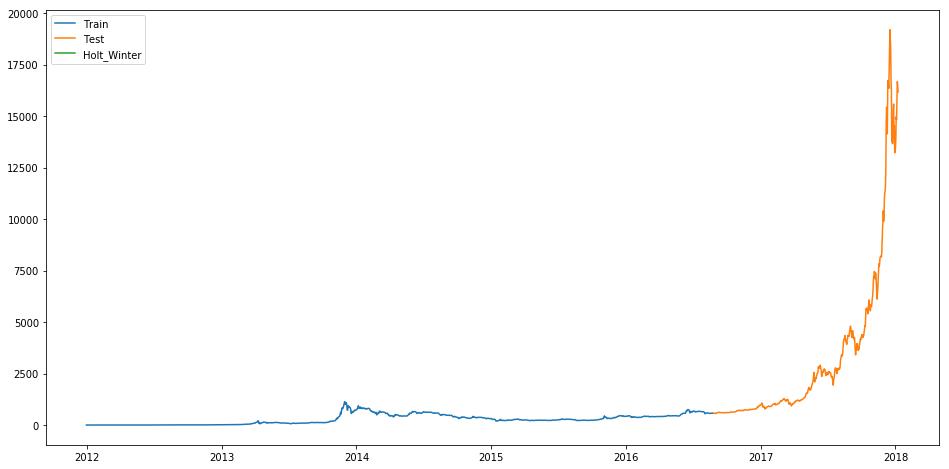

In [180]:
# y_hat_avg = test.copy()
# fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
# y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=60 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [181]:
rms = sqrt(mean_squared_error(test.Close, y_hat_avg.Holt_Winter))
print(rms)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [45]:
# # y_hat_avg = test.copy()
# # fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 2),seasonal_order=(0,1,1,7)).fit()
# # y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-06", end="2017-11-03", dynamic=True)

# y_hat_avg = test.copy()
# fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
# y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-04", end="2017-11-03", dynamic=True)

# # y_hat_avg = test.copy()
# # fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 1)).fit()
# # y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-06", end="2017-11-03", dynamic=True)

# # y_hat_avg = test.copy()
# # fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 2),seasonal_order=(-3,0,1,3)).fit()
# # y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-06", end="2017-11-03", dynamic=True)

# # y_hat_avg = test.copy()
# # fit1 = sm.tsa.statespace.SARIMAX(train.Close, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit(disp=-1)
# # y_hat_avg['SARIMA'] = fit1.predict(start="2017-06-06", end="2017-11-03", dynamic=True)

# plt.figure(figsize=(16,8))
# plt.plot( train['Close'], label='Train')
# plt.plot(test['Close'], label='Test')
# plt.plot(y_hat_avg['SARIMA'], label='SARIMA',linewidth=3)
# plt.legend(loc='best')
# plt.show()

In [46]:
# rms = sqrt(mean_squared_error(test.Close, y_hat_avg.SARIMA))
# print(rms)